In [76]:
%pip install pandas mlxtend matplotlib seaborn openpyxl


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Test1

In [77]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules
from datetime import timedelta
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import networkx as nx
import warnings


In [78]:
warnings.filterwarnings("ignore")

# ====== 1. Load and Clean Data ======
def load_and_clean(file_path, sheet="รายงานรายวัน"):
    df = pd.read_excel(file_path, sheet_name=sheet)
    df.columns = df.iloc[5]  # ใช้แถวที่ 6 เป็น header จริง
    df = df[6:].reset_index(drop=True)
    df = df[["รหัสสินค้า", "ชื่อสินค้า", "วันที่"]].dropna()
    df["วันที่"] = pd.to_datetime(df["วันที่"], dayfirst=True, errors="coerce")
    return df


In [79]:
# ====== 2. Load Data ======
df1 = load_and_clean("data/month1.xlsx")
df2 = load_and_clean("data/month2.xlsx")
df3 = load_and_clean("data/month3.xlsx")
df = pd.concat([df1, df2, df3], ignore_index=True)


In [80]:
# ====== 3. Merge categories ======
product_cats = pd.read_csv("data/Extracted_Product_Categories.csv")  # "ชื่อสินค้า", "หมวดหมู่"
df = df.merge(product_cats, on="ชื่อสินค้า", how="left")
df["category"] = df["หมวดหมู่"].astype(str)
df = df[df["category"] != "-"]


In [81]:
# ====== 4. Filter: 365 Latest day + Popular categories (≥ 3 times) ======
today = df["วันที่"].max()
df_recent = df[df["วันที่"] >= today - timedelta(days=365)]
popular = df_recent["category"].value_counts()
df_recent = df_recent[df_recent["category"].isin(popular[popular >= 3].index)]


In [82]:

# ====== 5. crate  Basket ======
grouped = df_recent.groupby("วันที่")["category"].apply(lambda x: list(set(x))).reset_index()
te = TransactionEncoder()
te_ary = te.fit(grouped["category"]).transform(grouped["category"])
basket = pd.DataFrame(te_ary, columns=te.columns_)


In [83]:
# ====== 6. Split Train/Test ======
train_basket, test_basket = train_test_split(basket, test_size=0.2, random_state=42)
print(f"🔧 Train Size: {len(train_basket)}, Test Size: {len(test_basket)}")


🔧 Train Size: 41, Test Size: 11


In [84]:
# # Best F1 score:  
# # Precision: 79.37%
# # Recall: 49.15%
# # F1 Score: 60.71%
# # ====== 7. FP-Growth Training ======
# frequent_itemsets = fpgrowth(train_basket, min_support=0.05, use_colnames=True, max_len=5)
# rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)
# rules = rules[rules["lift"] > 1.0]

# print(f"📦 Discovered Rules: {len(rules)}")
# print("\n📊 Top 100 Rules:")
# print(rules[["antecedents", "consequents",  "support", "confidence", "lift"]].head(100))


In [85]:


# # Best Precision 
# # Precision: 81.67%
# # Recall: 41.41%
# # F1 Score: 54.96%
# # ====== 7. FP-Growth Training ======
# frequent_itemsets = fpgrowth(train_basket, min_support=0.04, use_colnames=True, max_len=3)
# rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.75)
# rules = rules[rules["lift"] > 1.0].sort_values(by="confidence", ascending=False).reset_index(drop=True)

# print(f"📦 Discovered Rules: {len(rules)}")
# print("\n📊 Top 100 Rules:")
# print(rules[["antecedents", "consequents",  "support", "confidence", "lift"]].head(100))


In [86]:
# #  Balanced F1 score:


# # Precision: 71.20%
# # Recall: 57.68%
# # F1 Score: 63.73%
# # Best Precision 

# # ====== 7. FP-Growth Training ======
# frequent_itemsets = fpgrowth(train_basket, min_support=0.05, use_colnames=True, max_len=3)
# rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)
# rules = rules[rules["lift"] > 1.0].sort_values(by="confidence", ascending=False).reset_index(drop=True)

# print(f"📦 Discovered Rules: {len(rules)}")
# print("\n📊 Top 100 Rules:")
# print(rules[["antecedents", "consequents",  "support", "confidence", "lift"]].head(100))


In [87]:

# #  Balanced F1 score:
# # Precision: 70.78%
# # Recall: 51.79%
# # F1 Score: 59.82%
# # ====== 7. FP-Growth Training ======
# frequent_itemsets = fpgrowth(train_basket, min_support=0.04, use_colnames=True, max_len=3)
# rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.4)
# rules = rules[rules["lift"] > 1.0].sort_values(by="confidence", ascending=False).reset_index(drop=True)

# print(f"📦 Discovered Rules: {len(rules)}")
# print("\n📊 Top 100 Rules:")
# print(rules[["antecedents", "consequents",  "support", "confidence", "lift"]].head(100))


In [ ]:
# #  Balanced F1 score:


# # Precision: 79.90%
# # Recall: 56.06%
# # F1 Score: 65.89%
# # ====== 7. FP-Growth Training ======
# frequent_itemsets = fpgrowth(train_basket, min_support=0.06, use_colnames=True, max_len=3)
# rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)
# rules = rules[rules["lift"] > 1.0].sort_values(by="confidence", ascending=False).reset_index(drop=True)

# print(f"📦 Discovered Rules: {len(rules)}")
# print("\n📊 Top 100 Rules:")


📦 Discovered Rules: 957

📊 Top 100 Rules:
                              antecedents                  consequents  \
0            (ຢາສາມັນປະຈໍາບ້ານ, ເປັດຊີພີ)     (ແຈ່ວຊີ້ນດາດ - ຊີ້ນຈຸ່ມ)   
1                       (ເຄື່ອງໃຊ້ທົ່ວໄປ)      (ຊີ້ນສົດ, ຜັກປອດສານພິດ)   
2   (ແຈ່ວຊີ້ນດາດ - ຊີ້ນຈຸ່ມ, ອາຫານແຊ່ແຂງ)               (ຜັກປອດສານພິດ)   
3                       (ເຄື່ອງໃຊ້ທົ່ວໄປ)     (ນໍ້າແຈ່ວ, ຜັກປອດສານພິດ)   
4                (ແຈ່ວຊີ້ນດາດ - ຊີ້ນຈຸ່ມ)  (ອາຫານແຊ່ແຂງ, ຜັກປອດສານພິດ)   
..                                    ...                          ...   
95                                  (ຜັກ)     (ເຂົ້າໜົມ, ຜັກປອດສານພິດ)   
96                        (ຜັກ, ເຂົ້າໜົມ)               (ຜັກປອດສານພິດ)   
97                     (ຢາສາມັນປະຈໍາບ້ານ)               (ຜັກປອດສານພິດ)   
98                                  (ຜັກ)      (ຊີ້ນສົດ, ຜັກປອດສານພິດ)   
99                         (ຊີ້ນສົດ, ຜັກ)               (ຜັກປອດສານພິດ)   

     support  confidence      lift  
0   0.073171         1.0  1.5769

In [89]:

rules_display = rules.copy()
rules_display = rules_display.reset_index(drop=True)
rules_display.index.name = "ລຳດັບ"

# แปลงชุด antecedents และ consequents ให้อ่านง่าย
rules_display["ANTECEDENTS"] = rules_display["antecedents"].apply(lambda x: f"({', '.join(list(x))})")
rules_display["CONSEQUENTS"] = rules_display["consequents"].apply(lambda x: f"({', '.join(list(x))})")

# เลือกเฉพาะคอลัมน์ที่ต้องการแสดง
display_df = rules_display[["ANTECEDENTS", "CONSEQUENTS", "support", "confidence", "lift"]] \
    .rename(columns={
        "support": "SUPPORT", 
        "confidence": "CONFIDENCE", 
        "lift": "LIFT"
    })

# แสดงผลใน Jupyter หรือ VS Code (Jupyter Mode)
from IPython.display import display
display(display_df.head(100))  # แสดง 100 แถวแรก


,ANTECEDENTS,CONSEQUENTS,SUPPORT,CONFIDENCE,LIFT
ລຳດັບ,,,,,
0,"(ຢາສາມັນປະຈໍາບ້ານ, ເປັດຊີພີ)",(ແຈ່ວຊີ້ນດາດ - ຊີ້ນຈຸ່ມ),0.073171,1.0,1.576923
1,(ເຄື່ອງໃຊ້ທົ່ວໄປ),"(ຊີ້ນສົດ, ຜັກປອດສານພິດ)",0.536585,1.0,1.025000
2,"(ແຈ່ວຊີ້ນດາດ - ຊີ້ນຈຸ່ມ, ອາຫານແຊ່ແຂງ)",(ຜັກປອດສານພິດ),0.634146,1.0,1.025000
3,(ເຄື່ອງໃຊ້ທົ່ວໄປ),"(ນໍ້າແຈ່ວ, ຜັກປອດສານພິດ)",0.536585,1.0,1.025000
4,(ແຈ່ວຊີ້ນດາດ - ຊີ້ນຈຸ່ມ),"(ອາຫານແຊ່ແຂງ, ຜັກປອດສານພິດ)",0.634146,1.0,1.025000
...,...,...,...,...,...
95,(ຜັກ),"(ເຂົ້າໜົມ, ຜັກປອດສານພິດ)",0.609756,1.0,1.025000
96,"(ຜັກ, ເຂົ້າໜົມ)",(ຜັກປອດສານພິດ),0.609756,1.0,1.025000
97,(ຢາສາມັນປະຈໍາບ້ານ),(ຜັກປອດສານພິດ),0.292683,1.0,1.025000


In [90]:
frequent_itemsets = frequent_itemsets.reset_index(drop=True)
frequent_itemsets.index.name = "ລຳດັບ"
frequent_itemsets["ITEMSETS"] = frequent_itemsets["itemsets"].apply(lambda x: f"({', '.join(list(x))})")

result_df = frequent_itemsets[["support", "ITEMSETS"]].rename(columns={"support": "SUPPORT"})

from IPython.display import display
display(result_df.head(100))  # หรือ print(result_df.head(100)) ก็ได้


,SUPPORT,ITEMSETS
ລຳດັບ,,
0,1.0,(ອາຫານແຊ່ແຂງ)
1,1.0,(ເຄື່ອງດື່ມ)
2,1.0,(ຊີ້ນແພກແບຣນ)
3,1.0,(ນໍ້າແຈ່ວ)
4,1.0,(ອາຫານສຳເລັດຮູບ)
...,...,...
95,1.0,"(ຊີ້ນສົດ, ຊີ້ນແພກແບຣນ, ອາຫານສຳເລັດຮູບ)"
96,1.0,"(ຊີ້ນສົດ, ເຄື່ອງດື່ມ, ອາຫານສຳເລັດຮູບ)"
97,1.0,"(ຊີ້ນສົດ, ອາຫານສຳເລັດຮູບ, ອາຫານແຊ່ແຂງ)"


In [91]:
# from mlxtend.frequent_patterns import fpgrowth, association_rules
# from sklearn.model_selection import train_test_split
# from itertools import product
# import pandas as pd

# # เตรียม basket
# train_basket, test_basket = train_test_split(basket, test_size=0.2, random_state=42)

# # ค่าที่จะลอง
# support_range = [0.02, 0.03, 0.04, 0.05]
# confidence_range = [0.5, 0.6, 0.7, 0.75]

# results = []

# # วนทุก combination ของ min_support และ confidence
# for min_sup, min_conf in product(support_range, confidence_range):
#     frequent_itemsets = fpgrowth(train_basket, min_support=min_sup, use_colnames=True, max_len=5)
#     rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_conf)
#     rules = rules[rules["lift"] > 1.0]

#     tp = 0  # Predict correct
#     fp = 0  # Predict wrong
#     fn = 0  # Missed predict

#     for _, row in rules.iterrows():
#         antecedents = set(row["antecedents"])
#         consequents = set(row["consequents"])

#         for _, transaction in test_basket.iterrows():
#             basket_items = set(test_basket.columns[transaction])
#             if antecedents.issubset(basket_items):
#                 if consequents.issubset(basket_items):
#                     tp += 1
#                 else:
#                     fp += 1
#             elif consequents.issubset(basket_items):
#                 fn += 1

#     precision = tp / (tp + fp) if (tp + fp) > 0 else 0
#     recall = tp / (tp + fn) if (tp + fn) > 0 else 0
#     f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

#     results.append({
#         "min_support": min_sup,
#         "min_confidence": min_conf,
#         "rules": len(rules),
#         "precision": round(precision * 100, 2),
#         "recall": round(recall * 100, 2),
#         "f1_score": round(f1 * 100, 2)
#     })

# # แสดงผลลัพธ์
# df_results = pd.DataFrame(results).sort_values(by="f1_score", ascending=False).reset_index(drop=True)
# print(df_results)


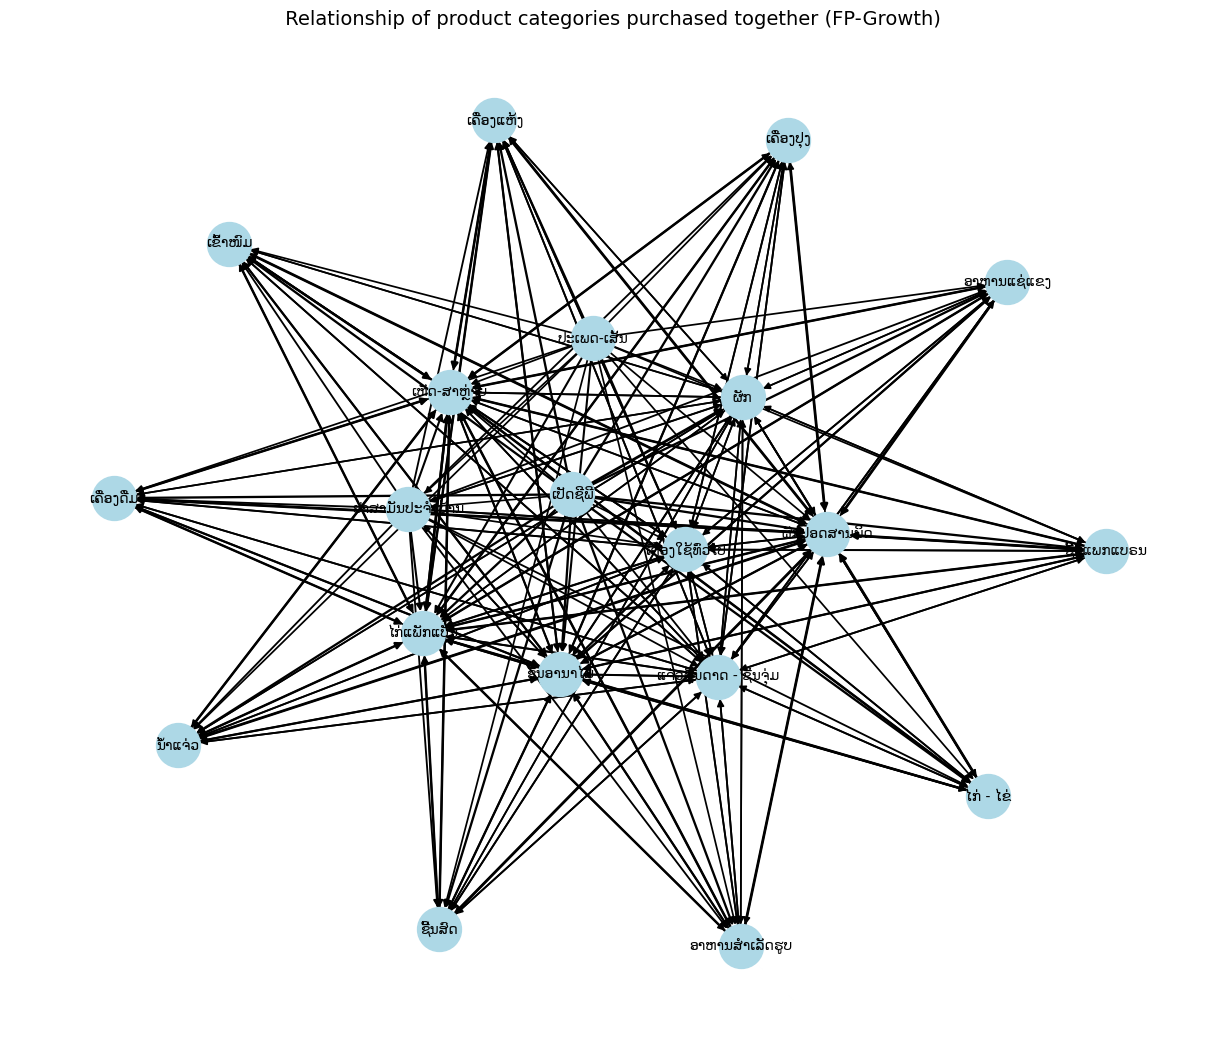

In [92]:

# ====== 9. Visualization ======
G = nx.DiGraph()
for _, row in rules.iterrows():
    for a in row['antecedents']:
        for c in row['consequents']:
            G.add_edge(str(a), str(c), weight=row['confidence'])

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, k=0.5)
edges = G.edges(data=True)
weights = [d['weight'] * 2 for (_, _, d) in edges]
nx.draw(G, pos, with_labels=True, node_size=1000, node_color="lightblue", font_size=10, arrows=True, width=weights)
plt.title(" Relationship of product categories purchased together (FP-Growth)", fontsize=14)
plt.show()


In [93]:
def recommend_next_items(items, rules, top_k=3):
    items = set(items)
    candidates = []

    for _, row in rules.iterrows():
        if items.issuperset(set(row["antecedents"])):
            for c in row["consequents"]:
                candidates.append((c, row["confidence"]))

    # Sort by confidence
    candidates = sorted(candidates, key=lambda x: x[1], reverse=True)

    # Remove duplicates
    seen = set()
    recommendations = []
    for item, _ in candidates:
        if item not in seen:
            recommendations.append(item)
            seen.add(item)
        if len(recommendations) == top_k:
            break
    return recommendations
print("Recommend:", recommend_next_items(["ຜັກປອດສານພິດ", "ເປັດຊີພີ"], rules))


Recommend: ['ແຈ່ວຊີ້ນດາດ - ຊີ້ນຈຸ່ມ', 'ນໍ້າແຈ່ວ', 'ຜັກປອດສານພິດ']


In [94]:
tp = 0  # Predicted correctly
fp = 0  # Wrong prediction
fn = 0  # Don't predict but should predict

for _, row in rules.iterrows():
    antecedents = set(row["antecedents"])
    consequents = set(row["consequents"])

    for _, transaction in test_basket.iterrows():
        basket_items = set(test_basket.columns[transaction])
        if antecedents.issubset(basket_items):
            if consequents.issubset(basket_items):
                tp += 1
            else:
                fp += 1
        elif consequents.issubset(basket_items):
            fn += 1

precision = tp / (tp + fp) if tp + fp > 0 else 0
recall = tp / (tp + fn) if tp + fn > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0

print(f"\nPrecision: {precision:.2%}")
print(f"Recall: {recall:.2%}")
print(f"F1 Score: {f1:.2%}")



Precision: 79.90%
Recall: 56.06%
F1 Score: 65.89%


In [95]:
from mlxtend.frequent_patterns import association_rules

# rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)
top10_rules = rules.sort_values(by='confidence', ascending=False).head(10)


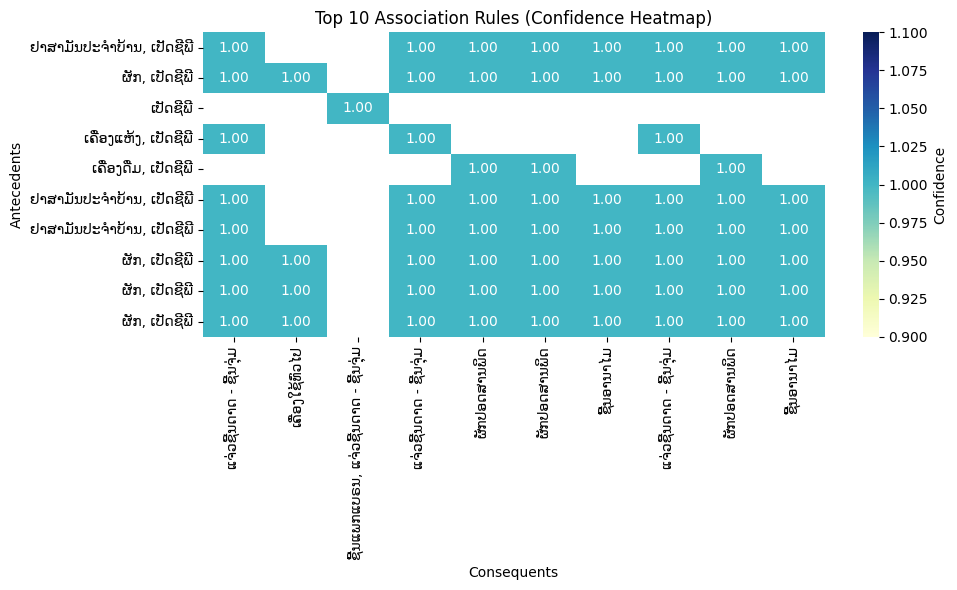

In [96]:
import seaborn as sns

# Convert names to be easy to read
def fs_to_str(fs):
    return ', '.join(sorted(fs))

top10_rules['antecedents_str'] = top10_rules['antecedents'].apply(fs_to_str)
top10_rules['consequents_str'] = top10_rules['consequents'].apply(fs_to_str)

# create  DataFrame for  heatmap
heatmap_df = pd.DataFrame(index=top10_rules['antecedents_str'],
                          columns=top10_rules['consequents_str'])

for _, row in top10_rules.iterrows():
    heatmap_df.loc[row['antecedents_str'], row['consequents_str']] = row['confidence']

# draw heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_df.astype(float), annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Confidence'})
plt.title("Top 10 Association Rules (Confidence Heatmap)")
plt.xlabel("Consequents")
plt.ylabel("Antecedents")
plt.tight_layout()
plt.show()


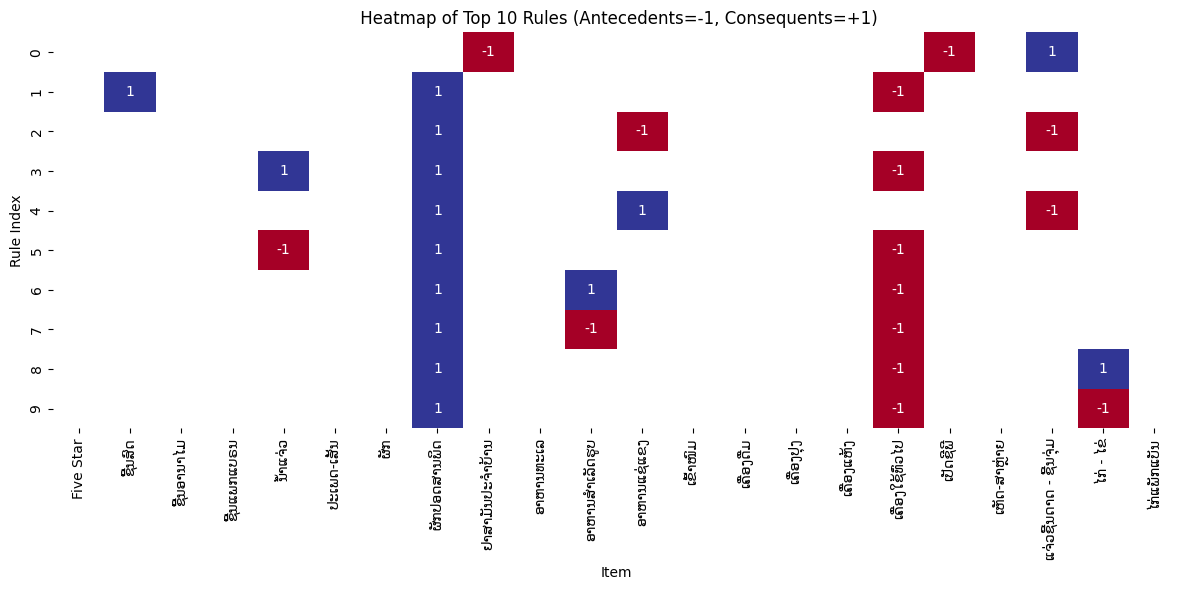

In [97]:
import numpy as np
import seaborn as sns

# Pull the Top 10 rules with the highest confidence
top_rules = rules.nlargest(10, 'confidence')

# สร้าง DataFrame สำหรับ Heatmap
heatmap_data = pd.DataFrame(0, index=range(10), columns=te.columns_)

for i, row in top_rules.iterrows():
    for item in row["antecedents"]:
        heatmap_data.loc[i, item] = -1  # use -1 instead antecedent
    for item in row["consequents"]:
        heatmap_data.loc[i, item] = 1   # use +1 instead consequent

# ✅ use np.nan instead None for not  dtype to  object
heatmap_data = heatmap_data.replace(0, np.nan)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, cmap="RdYlBu", center=0, cbar=False)
plt.title(" Heatmap of Top 10 Rules (Antecedents=-1, Consequents=+1)")
plt.xlabel("Item")
plt.ylabel("Rule Index")
plt.tight_layout()
plt.show()


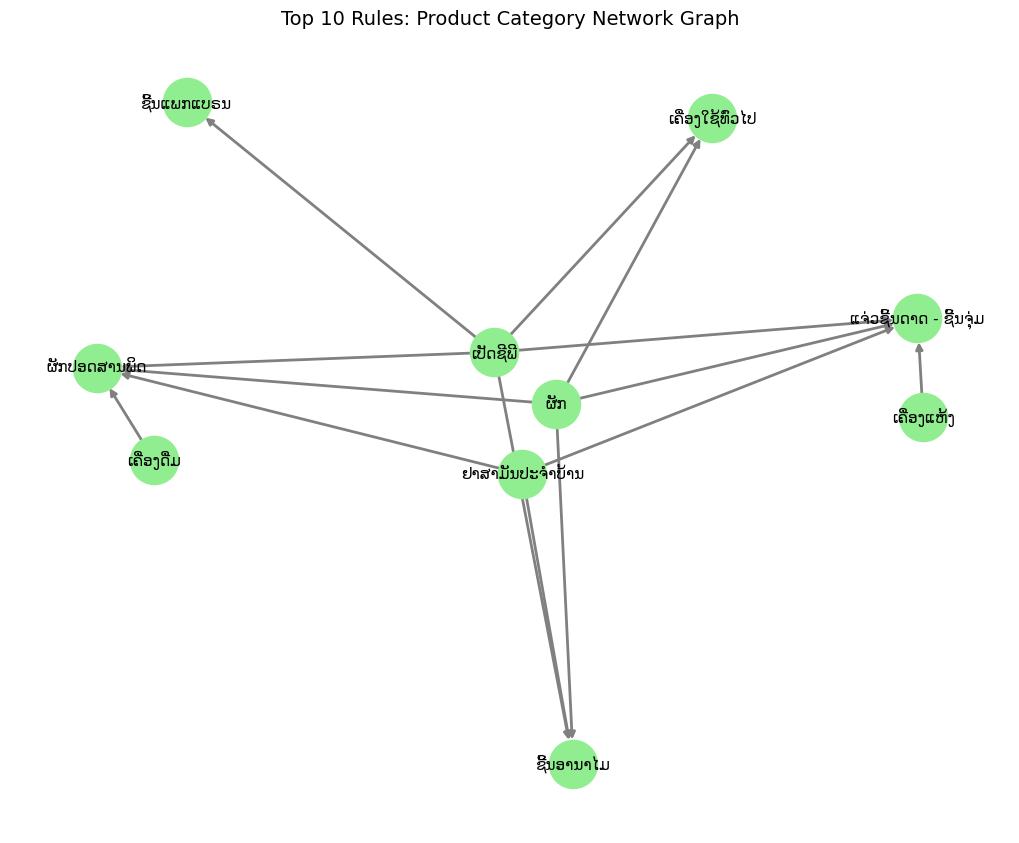

In [98]:
G = nx.DiGraph()
for _, row in top10_rules.iterrows():
    for a in row['antecedents']:
        for c in row['consequents']:
            G.add_edge(str(a), str(c), weight=row['confidence'])

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, k=0.5, seed=42)
edges = G.edges(data=True)
weights = [d['weight'] * 2 for (_, _, d) in edges]
nx.draw(G, pos, with_labels=True, node_size=1200, node_color="lightgreen",
        font_size=11, arrows=True, width=weights, edge_color="gray")
plt.title("Top 10 Rules: Product Category Network Graph", fontsize=14)
plt.show()


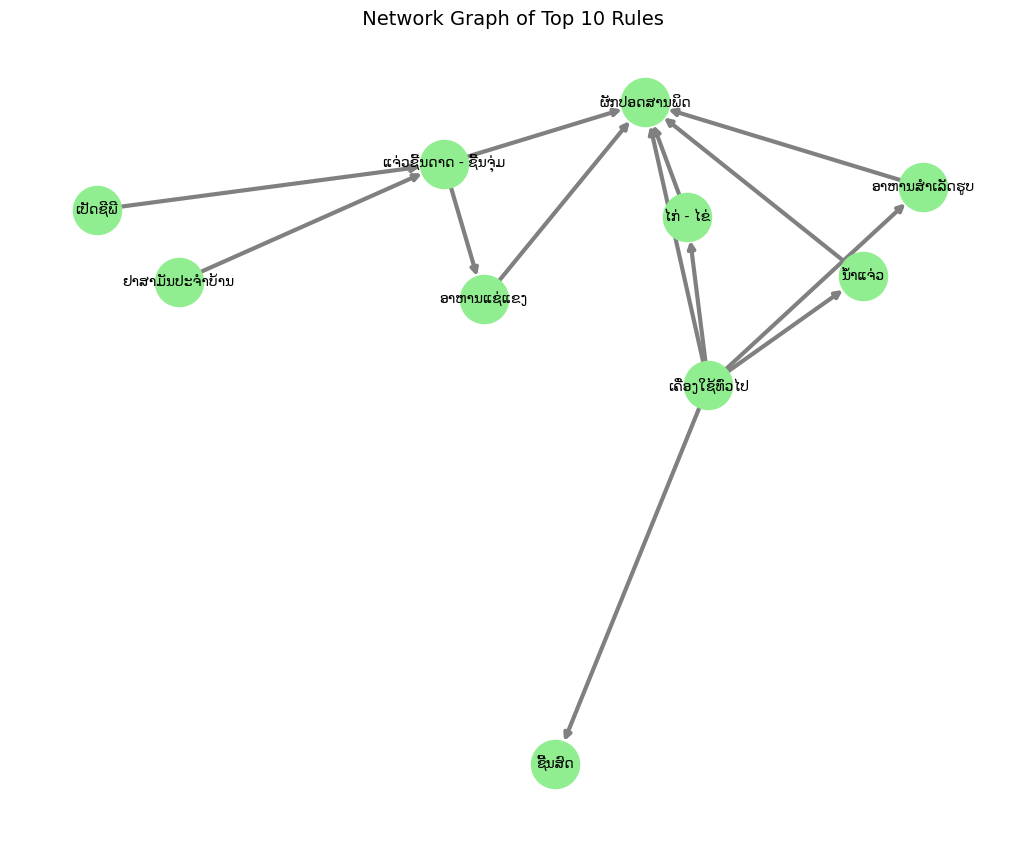

In [99]:
# use only  top 10 rules
top10_rules = rules.head(10)

G_top = nx.DiGraph()
for _, row in top10_rules.iterrows():
    for a in row['antecedents']:
        for c in row['consequents']:
            G_top.add_edge(str(a), str(c), weight=row['confidence'])

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G_top, k=0.7)
weights = [d['weight'] * 3 for (_, _, d) in G_top.edges(data=True)]
nx.draw(
    G_top, pos,
    with_labels=True,
    node_size=1200,
    node_color="lightgreen",
    font_size=10,
    arrows=True,
    width=weights,
    edge_color="gray"
)
plt.title(" Network Graph of Top 10 Rules", fontsize=14)
plt.show()


### Test2

Save file 

In [100]:
# rules['antecedents'] = rules['antecedents'].apply(list)
# rules['consequents'] = rules['consequents'].apply(list)
# rules.to_json("rules.json", orient="records", force_ascii=False)
